In [1]:
import random
import pandas as pd
import numpy as np
import os
import cv2

from sklearn import preprocessing
from tensorflow.keras import models, layers, Model, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Permute
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2, EfficientNetB0
#from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import Sequence ,to_categorical

import albumentations as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import warnings

In [2]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':5,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [3]:
df = pd.read_csv('./open/train.csv')

In [4]:
df

,id,img_path,A,B,C,D,E,F,G,H,I,J
0,TRAIN_00000,./train/TRAIN_00000.jpg,1,0,0,0,0,0,0,0,0,0
1,TRAIN_00001,./train/TRAIN_00001.jpg,1,0,0,0,0,0,0,0,0,0
2,TRAIN_00002,./train/TRAIN_00002.jpg,1,0,0,0,0,0,0,0,0,0
3,TRAIN_00003,./train/TRAIN_00003.jpg,1,0,0,0,0,0,0,0,0,0
4,TRAIN_00004,./train/TRAIN_00004.jpg,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32989,TRAIN_32989,./train/TRAIN_32989.jpg,1,0,0,0,1,0,1,1,1,1
32990,TRAIN_32990,./train/TRAIN_32990.jpg,1,0,0,0,0,1,1,1,1,1
32991,TRAIN_32991,./train/TRAIN_32991.jpg,1,0,0,0,0,1,1,1,1,1
32992,TRAIN_32992,./train/TRAIN_32992.jpg,1,0,0,0,0,1,1,1,1,1


In [5]:
from sklearn.model_selection import KFold

In [6]:
def get_labels(df):
    return df.iloc[:,2:].values

In [7]:
df['img_path'] = ['D:/ML/FoDBlock/open/' + path[2:] for path in df['img_path']]

In [8]:
X_T = df['img_path'].values
Y = get_labels(df)

In [9]:
test_img = cv2.imread(df['img_path'][0])
img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

In [10]:
from matplotlib import pyplot as plt

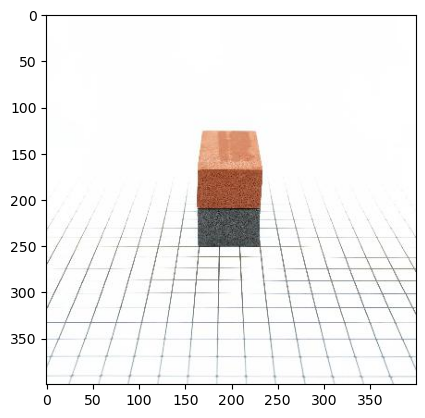

In [11]:
plt.imshow(img)

In [12]:
dst = np.where(img>250, 0, img)

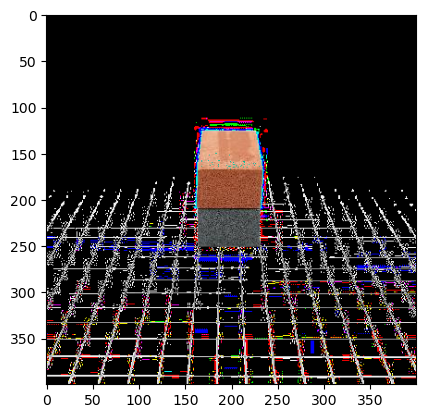

In [13]:
plt.imshow(dst)

In [14]:
def onChange(pos):
    pass

In [15]:
BG = "bg.jpg"

In [31]:
img = cv2.imread(df['img_path'][0])

In [32]:
def make_BG(img):
    img_bin = np.array(img[:, :, 0] < 200, dtype=np.uint8) * 255
    img_blur = cv2.medianBlur(img_bin, 5)
    img_filter = img.copy()
    img_filter[img_blur == 0] = 0
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img_blur)
    stats = np.array(stats)
    stats[0, -1] = 0
    label_idx = np.argmax(stats[:, -1])
    img_mask = labels == label_idx
    img_final = img_filter.copy()
    img_final[~img_mask] = (0, 0, 0)

    img_back = cv2.resize(cv2.imread(BG), img.shape[::-1][1:])
    img_back[img_mask] = (0, 0, 0)
    img_filter += img_back
    img_filter = cv2.cvtColor(img_filter, cv2.COLOR_BGR2RGB)
    return img_filter

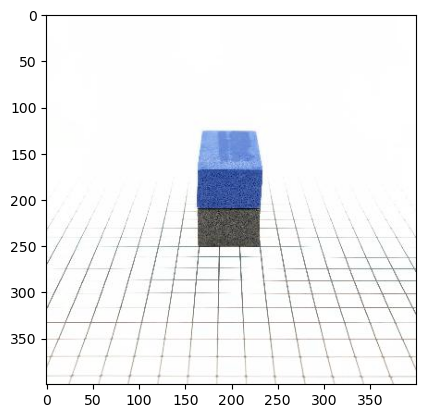

In [33]:
plt.imshow(img)

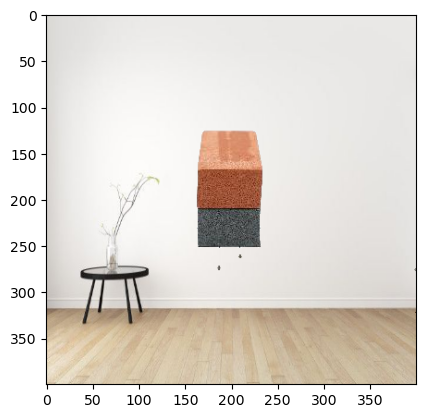

In [34]:
plt.imshow(make_BG(img))

In [35]:
kf = KFold(n_splits=10, shuffle=False)

In [36]:
class CustomDataset(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, shuffle = True):
        self.y = y_set
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indexes = np.arange(self.x.shape[0])
        self.shuffle = shuffle
        self.on_epoch_end()
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # 지정 배치 크기만큼 데이터를 로드합니다.
    def __getitem__(self, idx):
        inds = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        img_path = self.x[inds]
        #print(img_pth[0])
        batch_x = [make_BG(cv2.imread(x))for x in img_path]
        batch_y = self.y[inds]
        # augmentation을 적용해서 numpy array에 stack합니다.
        return np.stack([self.augment(image = x)["image"] for x in  batch_x], axis=0), np.array(batch_y)

In [37]:
train_transform = A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                             #A.Rotate(limit=90), A.VerticalFlip(p=0.5), A.HorizontalFlip(p= 0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0)
                            ])
valid_transform = A.Compose([A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), 
                            std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ])

In [38]:
import tensorflow as tf

In [39]:
def Create_Model():
    base_model = tf.keras.applications.EfficientNetB4(include_top=False,
                       input_shape=(CFG['IMG_SIZE'],CFG['IMG_SIZE'],3),
                       pooling='avg',
                       weights='imagenet')
    X = Flatten()(base_model.output)
    X = Dense(1024)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
    X = Dense(512)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.4)(X)
    X = Dense(10, activation='sigmoid')(X)
    image_model = Model(inputs = base_model.input, outputs = X)
    return image_model

In [40]:
image_model = Create_Model()
image_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 112, 112, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

 block3a_dwconv (DepthwiseConv2  (None, 28, 28, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 28, 28, 192)  768        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 28, 28, 192)  0          ['block3a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3a_se_squeeze (GlobalAver  (None, 192)         0           ['block3a_activation[0][0]']     
 agePoolin

 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block3c_se_reduce[0][0]']      
                                                                                                  
 block3c_se_excite (Multiply)   (None, 28, 28, 336)  0           ['block3c_activation[0][0]',     
                                                                  'block3c_se_expand[0][0]']      
          

 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 14)     4718        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 336)    5040        ['block4a_se_reduce[0][0]']      
                                                                                                  
 block4a_se_excite (Multiply)   (None, 14, 14, 336)  0           ['block4a_activation[0][0]',     
                                                                  'block4a_se_expand[0][0]']      
                                                                                                  
 block4a_project_conv (Conv2D)  (None, 14, 14, 112)  37632       ['block4a_se_excite[0][0]']      
          

                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 112)  0           ['block4c_project_bn[0][0]']     
                                                                                                  
 block4c_add (Add)              (None, 14, 14, 112)  0           ['block4c_drop[0][0]',           
                                                                  'block4b_add[0][0]']            
                                                                                                  
 block4d_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4c_add[0][0]']            
          

                                                                                                  
 block4e_add (Add)              (None, 14, 14, 112)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 14, 14, 672)  75264       ['block4e_add[0][0]']            
                                                                                                  
 block4f_expand_bn (BatchNormal  (None, 14, 14, 672)  2688       ['block4f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4f_expand_activation (Act  (None, 14, 14, 672)  0          ['block4f_expand_bn[0][0]']      
 ivation) 

 ivation)                                                                                         
                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 14, 14, 960)  24000      ['block5b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 960)  0          ['block5b_bn[0][0]']             
 )                                                                                                
          

 block5d_bn (BatchNormalization  (None, 14, 14, 960)  3840       ['block5d_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 960)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 960)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5d_se_squeeze[0][0]']     
          

                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 960)         0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block5f_se_reshape[0][0]']     
                                                                                                  
 block5f_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block5f_se_reduce[0][0]']      
                                                                                                  
 block5f_s

                                                                                                  
 block6b_se_expand (Conv2D)     (None, 1, 1, 1632)   112608      ['block6b_se_reduce[0][0]']      
                                                                                                  
 block6b_se_excite (Multiply)   (None, 7, 7, 1632)   0           ['block6b_activation[0][0]',     
                                                                  'block6b_se_expand[0][0]']      
                                                                                                  
 block6b_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6b_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6d_project_conv (Conv2D)  (None, 7, 7, 272)    443904      ['block6d_se_excite[0][0]']      
                                                                                                  
 block6d_project_bn (BatchNorma  (None, 7, 7, 272)   1088        ['block6d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6d_drop (Dropout)         (None, 7, 7, 272)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 272)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
          

                                                                                                  
 block6f_drop (Dropout)         (None, 7, 7, 272)    0           ['block6f_project_bn[0][0]']     
                                                                                                  
 block6f_add (Add)              (None, 7, 7, 272)    0           ['block6f_drop[0][0]',           
                                                                  'block6e_add[0][0]']            
                                                                                                  
 block6g_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6f_add[0][0]']            
                                                                                                  
 block6g_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block6g_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1632)   443904      ['block6h_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1632)  6528        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1632)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1632)  14688       ['block7a_expand_activation[0][0]
 D)       

 flatten (Flatten)              (None, 1792)         0           ['avg_pool[0][0]']               
                                                                                                  
 dense (Dense)                  (None, 1024)         1836032     ['flatten[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024)        4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 1024)         0           ['batch_normalization[0][0]']    
                                                                                                  
 dropout (Dropout)              (None, 1024)         0           ['activation[0][0]']             
          

In [41]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14224354859241605063
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22722641920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12716890046072407376
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [42]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
def mcp_save(p):
    return ModelCheckpoint('D:/ML/FodBlock/open/'+p+'model.h5', save_best_only=True, monitor='val_binary_accuracy', mode='max',save_weights_only=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [43]:
all_scores = []
all_preds = []
idx = 0
for train_index, test_index in kf.split(X_T):
    X_train, X_val = X_T[train_index], X_T[test_index]
    y_train, y_val = Y[train_index], Y[test_index]
    train_Dataset = CustomDataset(X_train, y_train, CFG['BATCH_SIZE'], train_transform)
    valid_Dataset = CustomDataset(X_val, y_val, CFG['BATCH_SIZE'], valid_transform, shuffle=False)
    image_model = Create_Model()
    image_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    history = image_model.fit(train_Dataset, validation_data=valid_Dataset, epochs= 30, callbacks=[earlyStopping, mcp_save(str(idx)), reduce_lr_loss])
    scores = image_model.evaluate(valid_Dataset)
    all_scores.append(scores)
    image_model.load_weights(filepath='D:/ML/FodBlock/open/'+str(idx)+'model.h5')
    #pred = image_model.predict(X_val)
    #all_preds.append(pred)
    idx += 1

Epoch 1/30
928/928 [==============================] - 358s 372ms/step - loss: 0.4463 - binary_accuracy: 0.7730 - val_loss: 0.5874 - val_binary_accuracy: 0.7751 - lr: 0.0010
Epoch 2/30
928/928 [==============================] - 355s 383ms/step - loss: 0.2060 - binary_accuracy: 0.9181 - val_loss: 0.8322 - val_binary_accuracy: 0.6613 - lr: 0.0010
Epoch 3/30
928/928 [==============================] - 355s 382ms/step - loss: 0.1521 - binary_accuracy: 0.9417 - val_loss: 1.9706 - val_binary_accuracy: 0.6832 - lr: 0.0010
Epoch 4/30
928/928 [==============================] - 351s 378ms/step - loss: 0.1254 - binary_accuracy: 0.9530 - val_loss: 0.6596 - val_binary_accuracy: 0.7185 - lr: 0.0010
Epoch 5/30
928/928 [==============================] - 353s 381ms/step - loss: 0.1086 - binary_accuracy: 0.9596 - val_loss: 0.4495 - val_binary_accuracy: 0.8011 - lr: 0.0010
Epoch 6/30
928/928 [==============================] - 353s 380ms/step - loss: 0.0972 - binary_accuracy: 0.9638 - val_loss: 0.3607 - val

928/928 [==============================] - 347s 374ms/step - loss: 0.0449 - binary_accuracy: 0.9835 - val_loss: 1.3977 - val_binary_accuracy: 0.5655 - lr: 0.0010
Epoch 16/30
928/928 [==============================] - 349s 376ms/step - loss: 0.0445 - binary_accuracy: 0.9838 - val_loss: 0.6878 - val_binary_accuracy: 0.7728 - lr: 0.0010
Epoch 17/30
928/928 [==============================] - 346s 372ms/step - loss: 0.0416 - binary_accuracy: 0.9847 - val_loss: 0.9120 - val_binary_accuracy: 0.6338 - lr: 0.0010
Epoch 18/30
928/928 [==============================] - 346s 372ms/step - loss: 0.0385 - binary_accuracy: 0.9859 - val_loss: 0.8902 - val_binary_accuracy: 0.6647 - lr: 0.0010
Epoch 19/30
928/928 [==============================] - 347s 373ms/step - loss: 0.0378 - binary_accuracy: 0.9863 - val_loss: 2.7550 - val_binary_accuracy: 0.6515 - lr: 0.0010
Epoch 20/30
928/928 [==============================] - 347s 374ms/step - loss: 0.0367 - binary_accuracy: 0.9865 - val_loss: 1.9083 - val_binar

Epoch 2/30
928/928 [==============================] - 351s 378ms/step - loss: 0.1993 - binary_accuracy: 0.9210 - val_loss: 0.4005 - val_binary_accuracy: 0.8262 - lr: 0.0010
Epoch 3/30
928/928 [==============================] - 350s 377ms/step - loss: 0.1441 - binary_accuracy: 0.9457 - val_loss: 0.4372 - val_binary_accuracy: 0.8030 - lr: 0.0010
Epoch 4/30
928/928 [==============================] - 352s 379ms/step - loss: 0.1194 - binary_accuracy: 0.9552 - val_loss: 1.9516 - val_binary_accuracy: 0.5227 - lr: 0.0010
Epoch 5/30
928/928 [==============================] - 351s 378ms/step - loss: 0.1029 - binary_accuracy: 0.9620 - val_loss: 0.8441 - val_binary_accuracy: 0.7016 - lr: 0.0010
Epoch 6/30
928/928 [==============================] - 352s 379ms/step - loss: 0.0907 - binary_accuracy: 0.9666 - val_loss: 0.9868 - val_binary_accuracy: 0.5077 - lr: 0.0010
Epoch 7/30
928/928 [==============================] - 352s 379ms/step - loss: 0.0828 - binary_accuracy: 0.9697 - val_loss: 0.8431 - val

928/928 [==============================] - 357s 385ms/step - loss: 0.0145 - binary_accuracy: 0.9945 - val_loss: 0.3068 - val_binary_accuracy: 0.9163 - lr: 1.0000e-05
Epoch 25/30
928/928 [==============================] - ETA: 0s - loss: 0.0144 - binary_accuracy: 0.9946
Epoch 25: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
928/928 [==============================] - 355s 383ms/step - loss: 0.0144 - binary_accuracy: 0.9946 - val_loss: 0.4054 - val_binary_accuracy: 0.8988 - lr: 1.0000e-05
Epoch 26/30
928/928 [==============================] - 355s 382ms/step - loss: 0.0140 - binary_accuracy: 0.9947 - val_loss: 0.3758 - val_binary_accuracy: 0.9048 - lr: 1.0000e-06
Epoch 27/30
928/928 [==============================] - 356s 383ms/step - loss: 0.0141 - binary_accuracy: 0.9947 - val_loss: 0.3799 - val_binary_accuracy: 0.9044 - lr: 1.0000e-06
Epoch 28/30
104/104 [==============================] - 33s 319ms/step - loss: 0.3643 - binary_accuracy: 0.9066
Epoch 1/30
928/928 

Epoch 9/30
928/928 [==============================] - 356s 383ms/step - loss: 0.0655 - binary_accuracy: 0.9760 - val_loss: 2.6333 - val_binary_accuracy: 0.4638 - lr: 0.0010
Epoch 10/30
928/928 [==============================] - ETA: 0s - loss: 0.0627 - binary_accuracy: 0.9770
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
928/928 [==============================] - 354s 381ms/step - loss: 0.0627 - binary_accuracy: 0.9770 - val_loss: 0.9790 - val_binary_accuracy: 0.6929 - lr: 0.0010
Epoch 11/30
928/928 [==============================] - 354s 381ms/step - loss: 0.0378 - binary_accuracy: 0.9861 - val_loss: 0.9083 - val_binary_accuracy: 0.6628 - lr: 1.0000e-04
Epoch 12/30
928/928 [==============================] - 352s 379ms/step - loss: 0.0293 - binary_accuracy: 0.9888 - val_loss: 3.2036 - val_binary_accuracy: 0.4637 - lr: 1.0000e-04
Epoch 13/30
928/928 [==============================] - 355s 382ms/step - loss: 0.0255 - binary_accuracy: 0.9904 - val_loss: 0.5

928/928 [==============================] - 458s 482ms/step - loss: 0.4043 - binary_accuracy: 0.8021 - val_loss: 0.9059 - val_binary_accuracy: 0.6021 - lr: 0.0010
Epoch 2/30
928/928 [==============================] - 494s 532ms/step - loss: 0.1854 - binary_accuracy: 0.9271 - val_loss: 1.1593 - val_binary_accuracy: 0.6567 - lr: 0.0010
Epoch 3/30
 31/928 [>.............................] - ETA: 5:19 - loss: 0.1547 - binary_accuracy: 0.9408

KeyboardInterrupt: 

In [44]:
all_scores

[[0.10134205967187881, 0.9750908017158508],
 [0.33266302943229675, 0.8962122797966003],
 [0.3432617485523224, 0.9274242520332336],
 [0.4983600676059723, 0.9060303568840027],
 [0.36432793736457825, 0.9066081047058105],
 [0.3566601872444153, 0.9237344861030579],
 [0.5062939524650574, 0.9004243016242981],
 [0.1413157731294632, 0.9656865000724792]]

In [45]:
class PredictDataset(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations, shuffle = True):
        self.y = y_set
        self.x = x_set
        self.batch_size = batch_size
        self.augment = augmentations
        self.indexes = np.arange(self.x.shape[0])
        self.shuffle = shuffle
        self.on_epoch_end()
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    # 지정 배치 크기만큼 데이터를 로드합니다.
    def __getitem__(self, idx):
        inds = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        img_path = self.x[inds]
        #print(img_pth[0])
        batch_x = [cv2.cvtColor(cv2.imread(x), cv2.COLOR_BGR2RGB)for x in img_path]
        batch_y = self.y[inds]
        # augmentation을 적용해서 numpy array에 stack합니다.
        return np.stack([self.augment(image = x)["image"] for x in  batch_x], axis=0), np.array(batch_y)

In [46]:
Ensemble_Model = []
for x in range(10):
    model = Create_Model()
    model.load_weights(filepath = 'D:/ML/FodBlock/open/'+str(x)+'model.h5')
    Ensemble_Model.append(model)

In [47]:
for x in Ensemble_Model:
    x.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    x.evaluate(valid_Dataset)

104/104 [==============================] - 36s 319ms/step - loss: 0.2820 - binary_accuracy: 0.9219


In [ ]:
import matplotlib.pyplot as plt
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=1)
plt.axis(xmax = 30)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [48]:
test = pd.read_csv('./open/test.csv')

In [49]:
test

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg
...,...,...
1455,TEST_01455,./test/TEST_01455.jpg
1456,TEST_01456,./test/TEST_01456.jpg
1457,TEST_01457,./test/TEST_01457.jpg
1458,TEST_01458,./test/TEST_01458.jpg


In [50]:
test['img_path'] = ['D:/ML/FoDBlock/open/' + path[2:] for path in test['img_path']]

In [51]:
test_dataset = PredictDataset(test['img_path'].values, test['id'].values, CFG['BATCH_SIZE'], valid_transform)

In [52]:
Predict = [x.predict(test_dataset) for x in Ensemble_Model]

46/46 [==============================] - 5s 73ms/step


In [53]:
Predict

[array([[4.17995006e-01, 8.88837099e-01, 1.57169312e-01, ...,
         5.17377723e-03, 2.54354984e-01, 2.51401693e-01],
        [1.49495425e-02, 3.00471280e-02, 9.99016404e-01, ...,
         1.97539004e-04, 2.12433785e-02, 9.67077017e-01],
        [1.62409358e-02, 1.88364815e-02, 9.99955177e-01, ...,
         1.61747099e-04, 7.21397344e-03, 8.81001819e-03],
        ...,
        [8.05262029e-01, 8.92613649e-01, 9.99874234e-01, ...,
         2.61929730e-04, 5.01811467e-02, 2.33181462e-01],
        [5.66213787e-01, 8.90760303e-01, 9.99383450e-01, ...,
         5.31922211e-04, 8.33054006e-01, 5.01993895e-02],
        [5.36326706e-01, 8.33410025e-01, 8.13683331e-01, ...,
         2.61125565e-01, 1.48026079e-01, 1.23163313e-01]], dtype=float32),
 array([[6.42093837e-01, 6.27355695e-01, 9.85151112e-01, ...,
         1.98721405e-04, 5.25644422e-01, 7.44131863e-01],
        [9.51013267e-02, 7.87707120e-02, 5.02190113e-01, ...,
         1.55605510e-01, 8.53991807e-01, 6.02405667e-01],
        [1

In [69]:
sum_array = np.zeros_like(Predict[0])

In [55]:
Probs = [X > 0.5 for X in Predict]
Probs

[array([[False,  True, False, ..., False, False, False],
        [False, False,  True, ..., False, False,  True],
        [False, False,  True, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False,  True, False],
        [ True,  True,  True, ..., False, False, False]]),
 array([[ True,  True,  True, ..., False,  True,  True],
        [False, False,  True, ..., False,  True,  True],
        [False, False,  True, ..., False,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]]),
 array([[ True,  True, False, ..., False, False,  True],
        [False,  True,  True, ..., False,  True, False],
        [ True,  True,  True, ..., False,  True, False],
        ...,
        [False,  True,  True, ..., False,  True, False],
        [ True,  True,  True, ...,  True, Fal

In [70]:
for x in range(8):
    sum_array = sum_array + Probs[x]
sum_array

array([[4., 5., 3., ..., 1., 5., 5.],
       [4., 5., 6., ..., 1., 5., 5.],
       [3., 5., 4., ..., 0., 4., 3.],
       ...,
       [4., 7., 4., ..., 0., 5., 2.],
       [4., 5., 4., ..., 1., 4., 2.],
       [7., 7., 7., ..., 2., 1., 2.]], dtype=float32)

In [71]:
sum_array = sum_array / 8
sum_array = sum_array > 0.5

In [72]:
sum_array 

array([[False,  True, False, ..., False,  True,  True],
       [False,  True,  True, ..., False,  True,  True],
       [False,  True, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False,  True, False],
       [False,  True, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])

In [73]:
sum_array = sum_array.astype(int)

In [74]:
submit = pd.read_csv('./open/sample_submission.csv')

In [75]:
submit.iloc[:,1:] = sum_array
submit.head()

,id,A,B,C,D,E,F,G,H,I,J
0,TEST_00000,0,1,0,0,0,0,0,0,1,1
1,TEST_00001,0,1,1,0,0,0,0,0,1,1
2,TEST_00002,0,1,0,0,0,0,0,0,0,0
3,TEST_00003,0,1,0,0,0,0,0,0,1,0
4,TEST_00004,1,1,0,0,0,0,0,0,0,0


In [76]:
submit.to_csv('./submit.csv', index=False)